In [35]:
file_path='/content/drive/MyDrive/GPT/the-verdict.txt'
with open(file_path, 'r', encoding='utf-8') as f:
  text_data=f.read()


**tokenizer**

In [36]:
import tiktoken
tokenizer=tiktoken.get_encoding("gpt2")
total_characters=len(text_data)
total_tokens=len(tokenizer.encode(text_data))

print(total_characters)
print(total_tokens)

20479
5145


**a dataset for batched inputs and targets**

In [37]:

import torch
from torch.utils.data import Dataset

class GPTDataset(Dataset):
    def __init__(self, text, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(text)

        for i in range(0, len(token_ids)-max_length, stride):
            input_chunk = token_ids[i:i+max_length]
            target_chunk = token_ids[i+1:i+1+max_length]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, index):
        return self.input_ids[index], self.target_ids[index]





**a dataloader for batched inputs**

In [38]:
from torch.utils.data import DataLoader

def create_dataloader(text, batch_size, max_length, stride, shuffle=True, drop_last=True, num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDataset(text=text, tokenizer=tokenizer,
                         max_length=max_length, stride=stride)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader



**loss across batch**

In [39]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), target_batch.flatten())

    return loss


**loss across dataloader**

In [40]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    if len(data_loader) == 0:
        return float('nan')
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch=input_batch, target_batch=target_batch, model=model, device=device)
            total_loss += loss.item()

        else:
            break
    return total_loss/num_batches


**text to token IDs**

In [41]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # added batch dim
    return encoded_tensor


**token IDs to text**

In [42]:
def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)  # remove batch dim
    return tokenizer.decode(flat.tolist())


**GPT text generate**

In [43]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :]
        probs = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probs, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)

    return idx


**multihead attention**

In [44]:
import torch.nn as nn
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()

        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        # reduce projection dim to match desired output dim
        self.head_dim = d_out//num_heads
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        # use linear layer to combine head output
        self.out_proj = nn.Linear(d_out, d_in)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            'mask',
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        # from (b, num_tokens, d_out) to (b, num_token, num_heads, head_dim) unrolling
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)

        # (b, num_tokens, num_heads, head_dim) to (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # keys (b, num_heads, num_tokens, head_dim) to (b, num_heads, head_dim, num_tokens)
        attn_scores = queries@keys.transpose(2, 3)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores/keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)
        context_vec = (attn_weights@values).transpose(1, 2)

        # combining heads: self.d_out=self.num_heads*self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)
        return context_vec


**layer normalization**

In [45]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x-mean)/torch.sqrt(var+self.eps)
        return self.scale*norm_x+self.shift


**GELU activation**

In [46]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5*x*(1+torch.tanh(torch.sqrt(torch.tensor(2.0/torch.pi))*(x+0.044715*torch.pow(x, 3))))



**feed forward layer**

In [47]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4*cfg["emb_dim"]),
            GELU(),
            nn.Linear(4*cfg["emb_dim"], cfg["emb_dim"])

        )

    def forward(self, x):
        return self.layers(x)


**transformer block**

In [48]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            dropout=cfg["drop_rate"],
            num_heads=cfg["n_heads"],
            qkv_bias=cfg["qkv_bias"]
        )

        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x+shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x+shortcut
        return x


**GPT model**

In [49]:
class GPTModel(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.tok_emb=nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb=nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb=nn.Dropout(cfg["drop_rate"])

        self.trf_blocks=nn.Sequential(
            *[TransformerBlock(cfg=cfg) for _ in range(cfg["n_layers"])]
        )

        self.final_norm=LayerNorm(cfg["emb_dim"])
        self.out_head=nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )


    def forward(self,in_idx): # in_idx: batch, no_tokens
        batch_size, seq_len=in_idx.shape
        tok_embeds=self.tok_emb(in_idx)
        pos_embeds=self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x=tok_embeds+pos_embeds
        x=self.drop_emb(x)
        x=self.trf_blocks(x)
        x=self.final_norm(x)
        logits=self.out_head(x)
        return logits



**evaluate model loss function**

In [50]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad(): # gradient tracking, dropout disabled
        train_loss=calc_loss_loader(train_loader,model, device,num_batches=eval_iter)
        val_loss=calc_loss_loader(val_loader,model,device,num_batches=eval_iter)

    model.train() # resetting in training mode
    return train_loss, val_loss


**generate and print samples**

In [51]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size=model.pos_emb.weight.shape[0]
    encoded=text_to_token_ids(start_context,tokenizer).to(device)
    with torch.no_grad():
        token_ids=generate_text_simple(idx=encoded,max_new_tokens=50,context_size=context_size,model=model)
        decoded_text=token_ids_to_text(token_ids,tokenizer)
        print(decoded_text)
    model.train()


**train LLM**

In [52]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen=[],[],[]
    tokens_seen, global_step=0,-1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss=calc_loss_batch(input_batch=input_batch,target_batch=target_batch,model=model,device=device)
            loss.backward()
            optimizer.step()
            tokens_seen+=input_batch.numel()
            global_step+=1

            if global_step%eval_freq==0:
                train_loss, val_loss=evaluate_model(model,train_loader,val_loader,device,eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)

                print(f"Epoch {epoch+1} (step{global_step:06d})| Train Loss {train_loss:.3f}| Val Loss {val_loss:.3f}")


        generate_and_print_sample(model,tokenizer,device,start_context)
    return train_losses,val_losses, track_tokens_seen



In [53]:
train_ratio=0.90
split_idx=int(train_ratio*len(text_data))
train_data=text_data[:split_idx]
val_data=text_data[split_idx:]


**GPT configuration of 124 parameter**

In [54]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,  # vocabsize from BPE tokenizer
    "context_length": 256,  # context length
    "emb_dim": 768,  # embedding dimension
    "n_heads": 12,  # number of attention heads
    "n_layers": 12,  # number of layers
    "drop_rate": 0.1,  # dropout rate
    "qkv_bias": False  # query-key-value bias
}


In [55]:
torch.manual_seed(123)

train_loader = create_dataloader(text=train_data, batch_size=2,
                                 max_length=GPT_CONFIG_124M["context_length"], stride=GPT_CONFIG_124M["context_length"], shuffle=True, drop_last=True, num_workers=0)
val_loader = create_dataloader(text=val_data, batch_size=2,
                               max_length=GPT_CONFIG_124M["context_length"], stride=GPT_CONFIG_124M["context_length"], shuffle=False, drop_last=False, num_workers=0)



In [56]:
torch.manual_seed(123)
model=GPTModel(GPT_CONFIG_124M)
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device=device)
optimizer=torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
num_epochs=10
train_losses, val_losses, tokens_seen=train_model_simple(model=model,train_loader=train_loader,val_loader=val_loader,optimizer=optimizer,device=device,num_epochs=num_epochs,eval_freq=5, eval_iter=1, start_context="Every effort moves you",tokenizer=tokenizer)



Epoch 1 (step000000)| Train Loss 10.062| Val Loss 9.930
Epoch 1 (step000005)| Train Loss 8.157| Val Loss 8.336
Every effort moves you,,,,,,,,,,,,.





































Epoch 2 (step000010)| Train Loss 6.554| Val Loss 7.053
Epoch 2 (step000015)| Train Loss 5.924| Val Loss 6.605
Every effort moves you, and,, and,,,,,,, and,.



































Epoch 3 (step000020)| Train Loss 5.813| Val Loss 6.507
Epoch 3 (step000025)| Train Loss 5.373| Val Loss 6.389
Every effort moves you, and to the to the of the to the, and I had. Gis, and, and, and, and, and, and I had the, and, and, and, and, and, and, and, and, and
Epoch 4 (step000030)| Train Loss 4.522| Val Loss 6.280
Epoch 4 (step000035)| Train Loss 4.986| Val Loss 6.304
Every effort moves you.

"I the picture.



















"I"I the picture"I had the the honour of the picture and I had been the picture of
Epoch 5 (step000040)| Train Loss 4.053| Val Loss 6.165
Every effort moves you know























In [57]:

import matplotlib.pyplot as plt
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
  fig, ax1=plt.subplots(figsize=(5,3))
  ax1.plot(epochs_seen, train_losses, label="Training Loss")
  ax1.plot(epochs_seen, val_losses, linestyle="-.", label='Validation Loss')
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel("Loss")
  ax1.legend(loc="upper right")
  ax2=ax1.twiny()
  ax2.plot(tokens_seen, train_losses, alpha=0)
  ax2.set_xlabel("Tokens seen")
  fig.tight_layout()
  plt.show()






**training and validation loss plot**

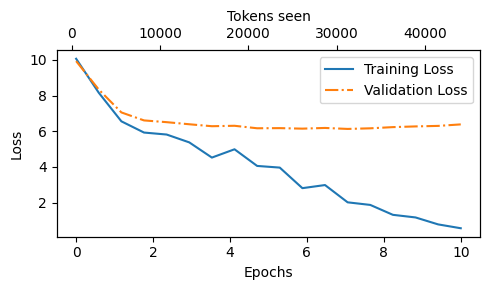

In [58]:
epochs_tensor=torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor,tokens_seen, train_losses, val_losses)


In [62]:
# generate text after training
torch.manual_seed(123)
token_ids=generate_text_simple(model=model, idx=text_to_token_ids("Every effort moves you",tokenizer).to(device), max_new_tokens=25, context_size=GPT_CONFIG_124M["context_length"])
print(token_ids_to_text(token_ids,tokenizer))


Every effort moves you?"
"Oh, and Mrs. Gisburn--as such--had not existed till nearly a year after Jack's


*we'll look into 2 new concepts to control randomness and diversity of the generated text: temperature scaling and top-k sampling*

**modifying the text generation function**

In [63]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.1, top_k=None, eos_id=None):
  for _ in range(max_new_tokens):
    idx_cond=idx[:,-context_size:]
    with torch.no_grad():
      logits=model(idx_cond)
    logits=logits[:,-1,:]
    if top_k is not None:
      top_logits, _ = torch.topk(logits, top_k)
      min_val=top_logits[:,-1]
      logits=torch.where(logits<min_val, torch.tensor(float('-inf')).to(logits.device),logits)


    if temperature>0.0:
      logits=logits/temperature
      probs=torch.softmax(logits,dim=-1)
      idx_next=torch.multinomial(probs, num_samples=1)
    else:
      idx_next=torch.argmax(logits, dim=-1, keepdim=True)
    if idx_next==eos_id:
      break
    idx=torch.cat((idx, idx_next), dim=-1)
  return idx



In [65]:
torch.manual_seed(123)
token_ids=generate(model=model, idx=text_to_token_ids("Every effort moves you",tokenizer).to(device),max_new_tokens=15,context_size=GPT_CONFIG_124M["context_length"],top_k=25,temperature=1.4)

print(token_ids_to_text(token_ids, tokenizer))


Every effort moves you was "Of his historyrow a for nothing--I Mrs. Professional people
